In [ ]:
!nvidia-smi

In [1]:
"""
Resnet-18 for classifying roof materials from PlanetScope SuperDove imagery
Case study in Washington, D.C. 
"""

import os, time, glob
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import xarray as xr
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
from shapely.geometry import box

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from torchsat.models.classification import resnet18
from torch.utils.data.dataloader import default_collate

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree

from fiona.crs import from_epsg

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

plt.ion() # interactive

# Projection information
wgs = from_epsg(4326)
proj = from_epsg(32618)
print(f'Projected CRS: {proj}')

print("Successfully imported all packages!")

Projected CRS: EPSG:32618
Successfully imported all packages!


In [2]:
class RoofImageDataset_Planet(Dataset):
    """Class to handle PlanetScope SuperDove imagery for Resnet-18"""

    def __init__(self, gdf, img_path, n_bands=8, imgdim=64, transform=None):
        """
        Args:
            gdf: Geodataframe containing 'geometry' column and 'class_code' column
            img_path: the path to the PlanetScope SuperDove composite image (single mosaic file)
                - see 'psscene-prep.py' for spectral indices calculation
            imgdim (int): Image dimension for CNN implementation
            transform (callable, optional): Optional transform to be applied on a sample

        Returns image chunks with class labels
        """

        if not os.path.exists(img_path):
            raise ValueError(f'Image does not exists: {img_path}')

        self.geometries = [p.centroid for p in gdf.geometry.values]
        self.img = img_path
        self.image_dim = imgdim # resnet window dimension, defaults to 64
        self.n_bands = n_bands
        self.Y = gdf.code.values
        # Define transforms
        if transform is not None:
            self.transform = transforms.Compose([
                transforms.Resize((self.image_dim, self.image_dim)),  # Resize to NxN for ResNet-18
                transforms.ToTensor()
            ])
        else:
            self.transform = transform
    
    def __len__(self):
        return len(self.geometries)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Sample the PlanetScope image
        left, bottom, right, top = self.geometries[idx].bounds
        geom = self.geometries[idx]

        try:
            sample = self.sample_image(geom)  # run the sampling function
            
            # if self.transform:
            #     sample = self.transform(sample)  # transform to common size

            cc = self.Y[idx]  # get the class codes
            
            # Ensure the sample has the correct dimensions
            if sample.shape[1:] != (self.image_dim, self.image_dim):
                raise ValueError(f'Invalid sample shape: {sample.shape}')
                        
        except Exception as e:
            print(f"Skipping invalid sample at index {idx}: {e}")
            return None  # Return None for invalid samples
        
        # Convert the sample array to a Torch object
        sample = torch.from_numpy(sample)

        return {'image': sample.type(torch.FloatTensor),
                'code': torch.tensor(cc).type(torch.LongTensor)}
        
        
    def sample_image(self, geom):
        # Sample the image at each geometry
        samples = [] # store the samples in a list

        N = self.image_dim
        half_N = self.image_dim / 2
            
        # Use the windows.from_bounds() method to return the window
        # Returns image chunks from training data locations
        with rio.open(self.img) as src:
            py, px = src.index(geom.x, geom.y)
            window = rio.windows.Window(px - N // 2, py - N // 2, N, N)
            
            # Read the data in the window
            # clip is a nbands * N * N numpy array
            clip = src.read(window=window)

            # Handle the case where the sample is smaller than the expected size
            if clip.shape != (self.n_bands, N, N):
                raise ValueError(f'Invalid sample shape: {clip.shape}\nAttempting to create padding ...')
                padding = [(0, 0), (0, max(0, N - clip.shape[1])), (0, max(0, N - clip.shape[2]))]
                clip = np.pad(clip, padding, mode='constant', constant_values=0)
            else:
                samples.append(clip)

            del clip, py, px, window

        # Convert the image chunk to a numpy array
        samples_arr = np.array(samples)

        del samples # Clear up memory

        # Make sure there is valid data
        if samples_arr.sum() > 0:
            ans = np.ma.masked_equal(samples_arr, 0).mean(axis=0)
        else:
            ans = samples_arr.mean(axis=0)

        del samples_arr

        return ans


def make_good_batch(batch):
    """
    Removes bad samples if image dimensions do not match.
    Args:
        - batch: list of dictionaries, each containing 'image' tensor and 'code' tensor
    returns: list of dictionaries same as input with samples having non-matching image dims removed
    """
    valid_samples = []
    for sample in batch:
        if sample is not None:
            image, code = sample['image'], sample['code']
            if code != 255 and not torch.isnan(code) and not torch.isinf(code):
                if not torch.isnan(image).any() and not torch.isinf(image).any():
                    if image.shape == (8, 64, 64):  # Ensure dimensions match
                        valid_samples.append(sample)
            del image, code

    if not valid_samples:
        return None

    return default_collate(valid_samples)
    del valid_samples, sample


def objective_fun(trial, train_da, val_da, N_classes, Class_weights):
    """ Objective function for hyperparameter tuning """
    """
    Function for fine-tuning Resnet-18 model using 'optuna' Python package
    Args:
        - trial: Optuna trial
        - tds: training dataset
        - vds: validation dataset
    """

    # Suggest hyperparameters to test
    batch_size = trial.suggest_int('batch_size', 16, 64)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    momentum = trial.suggest_uniform('momentum', 0.8, 0.99)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)

    # Load the train, test, and validation
    train_loader = DataLoader(train_da, batch_size=batch_size, shuffle=True, collate_fn=make_good_batch)
    val_loader = DataLoader(val_da, batch_size=batch_size, shuffle=False, collate_fn=make_good_batch)

    # Model definition
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(in_features, N_classes)  # NN = number of classes
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = nn.DataParallel(model)
    model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss(weight=Class_weights)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    # Training loop
    model.train()
    for epoch in range(10):  # Adjust number of epochs as needed
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    # Validation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

print("Class and functions ready to use!")

Class and functions ready to use!


In [3]:
os.chdir('/home/jovyan')
print(os.getcwd())

/home/jovyan


In [4]:
# Load the training data (footprints)
gdf_path = os.path.join('data/dc_data_reference_footprints.gpkg')
ref = gpd.read_file(gdf_path)
ref.head()

,class_code,areaUTMsqft,uid,description,code,geometry
0,CS,357.783709,1CS,Composition Shingle,0,"POLYGON ((324215.868 4313568.665, 324215.792 4..."
1,CS,918.640862,2CS,Composition Shingle,0,"POLYGON ((324602.816 4311717.247, 324604.322 4..."
2,CS,1383.414170,3CS,Composition Shingle,0,"POLYGON ((327253.581 4300371.859, 327258.154 4..."
3,CS,836.410297,4CS,Composition Shingle,0,"POLYGON ((333608.13 4306267.691, 333607.957 43..."
4,CS,330.514264,5CS,Composition Shingle,0,"POLYGON ((326482.699 4300939.466, 326487.386 4..."


In [5]:
# Calculate the 'optimal' window size from the footprint areas
mean_area_sqft = int(ref.areaUTMsqft.values.mean())
pct90_area_sqft = np.percentile(ref.areaUTMsqft, 90)
print(f'Mean footprint area (sqm): {mean_area_sqft * 0.092903}')
print(f'90th percentile footprint area (sqm): {pct90_area_sqft * 0.092903}')
# Convert sqft to sqm
pct90_area_sqm = pct90_area_sqft * 0.092903
# Calculate the side length ('optimal' window size) * 3 
print(f'90th percentile side length (m): {int(np.sqrt(pct90_area_sqm))}')
window_size = (int(np.sqrt(pct90_area_sqm) * 3) - 1)
print(f'Optimal window size: {window_size}')

Mean footprint area (sqm): 99.499113
90th percentile footprint area (sqm): 158.13312473978425
90th percentile side length (m): 12
Optimal window size: 36


In [1]:
# Observe the class imbalance in the reference data
print("Class counts:\n")
ref.class_code.value_counts()

Class counts:



NameError: name 'footprints' is not defined

In [8]:
# Merge the shingle classes (wood shingle and shingle)
merge = {'WS': 'WSH', 'SH': 'WSH'}
ref['class_code'].replace(merge, inplace=True)
ref['code'], _ = pd.factorize(ref['class_code']) # create a factorized version
print(ref['class_code'].value_counts())  # check the counts

class_code
ME     29651
CS     27687
SL     11080
WSH     1455
UR      1018
TL       617
Name: count, dtype: int64


In [15]:
# Create a dictionary mapping class_code to code
class_mapping = dict(zip(ref['class_code'], ref['code']))
print(class_mapping)

{'CS': 0, 'ME': 1, 'SL': 2, 'UR': 3, 'TL': 4, 'WSH': 5}


In [16]:
# Split into train/test for each class
train_df, test_df, val_df = [], [], []

# Define split ratios
ts = 0.8  # Test size ratio
vs = 0.2  # Validation size ratio from remaining

# Perform initial stratified split to separate training data from test+validation data
train_df, temp_df = train_test_split(
    ref, # our filtered samples
    test_size=ts, 
    random_state=27, 
    stratify=training_gdf['code']
)

# Perform stratified split on the temp_df to create validation and test sets
val_size = vs / (1 - ts)  # Adjust validation size to account for the initial split
val_df, test_df = train_test_split(
    temp_df, 
    test_size=vs, 
    random_state=27, 
    stratify=temp_df['code']
)

# Print the class distribution in validation and test sets to verify stratification
print("Train class distribution:\n", train_df['code'].value_counts())
print("Validation class distribution:\n", val_df['code'].value_counts())

Train class distribution:
 code
1    17031
0    14621
2     4941
5      285
3      151
4      119
Name: count, dtype: int64
Validation class distribution:
 code
1    7569
0    6498
2    2196
5     127
3      67
4      53
Name: count, dtype: int64
Test class distribution:
 code
1    3785
0    3250
2    1098
5      63
3      34
4      26
Name: count, dtype: int64


In [17]:
# Load our image data to check on the format
stack_da_fp = os.path.join('data/dc_data_psscene15b_norm_r.tif')
stack_da = rxr.open_rasterio(stack_da_fp, mask=True, cache=False).squeeze()
print(stack_da.shape)
print(
    f"shape: {img.rio.shape}\n"
    f"resolution: {img.rio.resolution()}\n"
    f"bounds: {img.rio.bounds()}\n"
    f"sum: {img.sum().item()}\n"
    f"CRS: {img.rio.crs}\n"
    f"NoData: {img.rio.nodata}"
    f"Array: {img}"
)
del stack_da

(8, 7555, 6046)
shape: (7555, 6046)
resolution: (3.0, -3.0)
bounds: (316269.0, 4295631.0, 334407.0, 4318296.0)
sum: 4.670212268829346
CRS: EPSG:32618
NoData: NoneArray: <xarray.DataArray (band: 8, y: 7555, x: 6046)> Size: 1GB
[365420240 values with dtype=float32]
Coordinates:
  * band         (band) int64 64B 1 2 3 4 5 6 7 8
  * x            (x) float64 48kB 3.163e+05 3.163e+05 ... 3.344e+05 3.344e+05
  * y            (y) float64 60kB 4.318e+06 4.318e+06 ... 4.296e+06 4.296e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_IMAGEDESCRIPTION:  {"atmospheric_correction": {"aerosol_model": "...
    TIFFTAG_DATETIME:          2022:06:05 14:56:31
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        15203
    STATISTICS_MEAN:           662.44066810447
    STATISTICS_MINIMUM:        80
    STATISTICS_STDDEV:         475.12461911944
    STATISTICS_VALID_PERCENT:  42.96
    AREA_OR_POINT:             Area
    scale_factor:              1.0
    add_offset:                0.0
  

In [27]:
# Set up the Resnet-18 model

# Define whether to leverage cpu or gpu (for my local machine it is only cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu
print(f'Using {device} for model dev ...')

# Grab the number of classes
n_classes = training_gdf.class_code.unique().shape[0]
print(f'There are {n_classes} roof type classes.')

# Define the Resnet-18 model
model = resnet18(n_classes, in_channels=8, pretrained=False)

# Make model parallel and on GPU
if torch.cuda.device_count() >= 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
    model.to(device)
else:
    #ps_model = nn.DataParallel(ps_model)
    model = nn.DataParallel(model)
    print('Made cpu parallel')

# optim and lr scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
# lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-8) # for resuming training?
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

Using cuda for model dev ...
There are 6 roof type classes.
Let's use 1 GPUs!


In [28]:
# Number of samples in each class
val_counts = list(train_df['code'].value_counts())
print(val_counts)

total_samples = sum(val_counts)

# Calculate class weights
class_weights = [total_samples / count for count in val_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Print the calculated class weights for verification
print(f"Class weights: {class_weights}")

# Loss
criterion = nn.CrossEntropyLoss(weight=class_weights)

[17031, 14621, 4941, 285, 151, 119]
Class weights: tensor([  2.1812,   2.5407,   7.5183, 130.3439, 246.0132, 312.1681],
       device='cuda:0')


In [29]:
import gc
gc.collect()

1750

In [30]:
t0 = time.time()

print_freq=100
losses = []
epoch_loss = []
val_losses = []

start_epoch = 0
num_epochs=20
for epoch in range(start_epoch, num_epochs):
    #writer.add_scalar('train/learning_rate', lr_scheduler.get_lr()[0], epoch)
    print(f'learning rate: {lr_scheduler.get_lr()[0]}, epoch {epoch}')

    def check_for_nan_inf(tensor):
        return torch.isnan(tensor).any() or torch.isinf(tensor).any()
    
    model.train()
    for idx, batch in enumerate(train_loader):
        
        # extract samples
        image, target = batch['image'], batch['code']

        # Check for NaN values in the data
        if check_for_nan_inf(image):
            print(f'NaN or Inf found in image data at batch {idx}')
            del image, target, batch
            gc.collect()
            continue
        if check_for_nan_inf(target):
            print(f'NaN or Inf found in target data at batch {idx}')
            del image, target, batch
            gc.collect()
            continue
            
        image, target = image.to(device), target.to(device)
        
        output = model(image.float()) 
        loss = criterion(output, target.long())
            
        if check_for_nan_inf(loss):
            print(f'NaN or Inf found in loss at batch {idx}')
            del image, target, batch, output, loss
            gc.collect()
            break
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if idx % print_freq == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, idx * len(image), len(train_loader.dataset), 100. * idx / len(train_loader), loss.item()))
            #writer.add_scalar('train/loss', loss.item(), len(data_loader) * epoch + idx)
            print(f'train/loss {loss.item()} {len(train_loader) * epoch + idx}')
            losses.append((idx, loss.item()))

        # Clear variables to free up memory
        del image, target, batch, output, loss
        gc.collect()
        
    #train_one_epoch(model, criterion, optimizer, train_loader, device, epoch, args.print_freq, writer)
    
    lr_scheduler.step()
    
    # average loss for the epoch
    epoch_loss.append(np.array(losses)[:,1].mean())
    
    ## need validation dataset
    #evaluate(epoch, model, criterion, val_loader, device, writer)
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for idx, batch in enumerate(val_loader):
                
            # extract samples
            image, target = batch['image'], batch['code']

            image = image.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            output = model(image)
            val_loss += criterion(output, target).item()

            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

             # Clear variables to free up memory
            del image, target, batch, output, pred
            gc.collect()
            
        val_loss /= len(val_loader.dataset)/val_loader.batch_size

        val_losses.append(val_loss)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            val_loss, correct, len(val_loader.dataset),
            100. * correct / len(val_loader.dataset)))
    
    # save_checkpoint(model, optimizer, epoch, epoch_loss[-1])

    t1 = (time.time() - t0) / 60
    print(f"Total elapsed time for epoch {epoch}: {t1:.2f} minutes.")
    print("\n~~~~~~~~~~\n")
    
    gc.collect()
    
    # torch.save(model.state_dict(), os.path.join(checkpoint_dir, "cls_epoch_{}.pth".format(epoch)))

t2 = (time.time() - t0) / 60
print(f"Total elapsed time: {t2:.2f} minutes.")

learning rate: 0.001, epoch 0
Train Epoch: 0 [0/37148 (0%)]	Loss: 1.928135
train/loss 1.9281353950500488 0
Train Epoch: 0 [12200/37148 (34%)]	Loss: 1.666880
train/loss 1.6668797731399536 100
Train Epoch: 0 [24800/37148 (69%)]	Loss: 1.063754
train/loss 1.0637538433074951 200

Test set: Average loss: 1.3843, Accuracy: 6999/16510 (42%)

Total elapsed time for epoch 0: 11.21 minutes.

~~~~~~~~~~

learning rate: 0.001, epoch 1
Train Epoch: 1 [0/37148 (0%)]	Loss: 1.138035
train/loss 1.138034701347351 291
Train Epoch: 1 [12300/37148 (34%)]	Loss: 1.479018
train/loss 1.479017734527588 391
Train Epoch: 1 [24800/37148 (69%)]	Loss: 1.086442
train/loss 1.0864417552947998 491

Test set: Average loss: 1.2579, Accuracy: 7935/16510 (48%)

Total elapsed time for epoch 1: 22.48 minutes.

~~~~~~~~~~

learning rate: 0.001, epoch 2
Train Epoch: 2 [0/37148 (0%)]	Loss: 1.151215
train/loss 1.1512153148651123 582
Train Epoch: 2 [12400/37148 (34%)]	Loss: 1.094585
train/loss 1.0945854187011719 682
Train Epoch: 2 

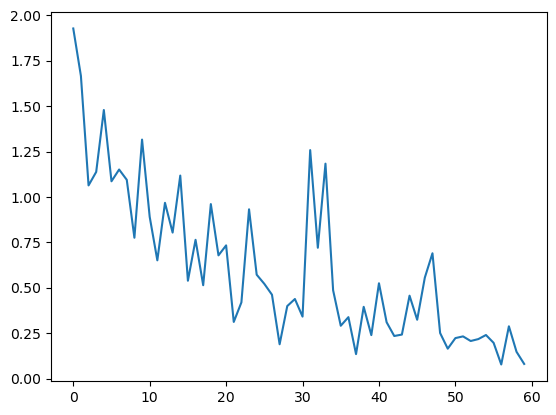

In [31]:
# Plot the model loss function
plt.plot(np.array(losses)[:,1])

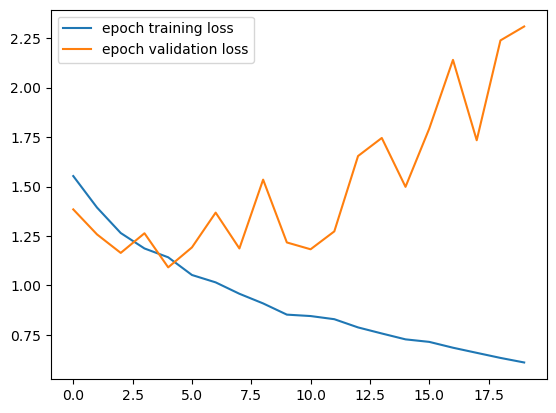

In [32]:
# Epoch training loss
plt.plot(epoch_loss, label='epoch training loss')
plt.plot(val_losses, label='epoch validation loss')
plt.legend()
plt.show()

In [33]:
os.getcwd()

'/home/jovyan'

In [35]:
# Save the model

save_res = True

if save_res:
    # directory
    save_dir = 'results/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # save the model
    step = len(losses)
    model_path = 'dc_planet_ms_ep{}_step{}_b{}.pt'.format(num_epochs, step, bs)
    model_path = os.path.join(save_dir, model_path)
    save = lambda ep: torch.save({
            'model': model.state_dict(),
            'epoch': epoch,
            'step': step,
        }, str(model_path))

    save(model_path)

In [36]:
np.savetxt(os.path.join(save_dir, 'losses_ep{}_step{}_b{}.txt'.format(num_epochs, step, bs)), np.array(losses))
np.savetxt(os.path.join(save_dir, 'epoch_loss_ep{}_step{}_b{}.txt'.format(num_epochs, step, bs)), np.array(epoch_loss))
np.savetxt(os.path.join(save_dir, 'val_losses_ep{}_step{}_b{}.txt'.format(num_epochs, step, bs)), np.array(val_losses))

In [37]:
import gc

def get_prediction(m, s):
    s = s.to(device)  # Ensure the sample is moved to the correct device
    res = m(s)
    return res

true_labels = []
pred_labels = []

model.eval()  # Set model to evaluation mode

for idx, sample in enumerate(test_ds):
    try:
        if sample['code'] != 255:
            # Append true labels
            true_labels.append(sample['code'].item())  # Convert tensor to Python scalar
                        
            # Get prediction and append
            pred = get_prediction(model, sample['image'][None, ...].float().to(device))  # Ensure tensor is float and on the correct device
            pred_labels.append(pred.argmax().item())  # Convert tensor to Python scalar
            
        else:
            print(f'sample {idx} of {len(test_ds)} had class label 255, skipping...')
        
        if idx % 100 == 0:
            time.sleep(0.3)
            gc.collect()
            print(f'Processed {idx} samples...')
        
    except Exception as e:
        print(f'Error at sample {idx}: {e}, continuing...')

Processed 0 samples...
Processed 100 samples...
Processed 200 samples...
Processed 300 samples...
Processed 400 samples...
Processed 500 samples...
Processed 600 samples...
Processed 700 samples...
Processed 800 samples...
Processed 900 samples...
Processed 1000 samples...
Processed 1100 samples...
Processed 1200 samples...
Processed 1300 samples...
Processed 1400 samples...
Processed 1500 samples...
Processed 1600 samples...
Processed 1700 samples...
Processed 1800 samples...
Processed 1900 samples...
Processed 2000 samples...
Processed 2100 samples...
Processed 2200 samples...
Processed 2300 samples...
Processed 2400 samples...
Processed 2500 samples...
Processed 2600 samples...
Processed 2700 samples...
Processed 2800 samples...
Processed 2900 samples...
Processed 3000 samples...
Processed 3100 samples...
Processed 3200 samples...
Processed 3300 samples...
Processed 3400 samples...
Processed 3500 samples...
Processed 3600 samples...
Processed 3700 samples...
Processed 3800 samples..

In [38]:
# Ensure 'class_code' is of categorical dtype
test_df['code'] = test_df['code'].astype('category')

# Create the dictionary mapping
cat_dict = dict(enumerate(test_df['code'].cat.categories))
print(cat_dict)

# Filter the class codes present in the test set
class_codes_numbers = [k for k in cat_dict.keys() if cat_dict[k] in test_df['code'].unique().tolist()]

cor_labels = [cat_dict[c] for c in class_codes_numbers]
print(cor_labels)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
[0, 1, 2, 3, 4, 5]


(array([3250.,    0., 3785.,    0., 1098.,    0.,   34.,    0.,   26.,
          63.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

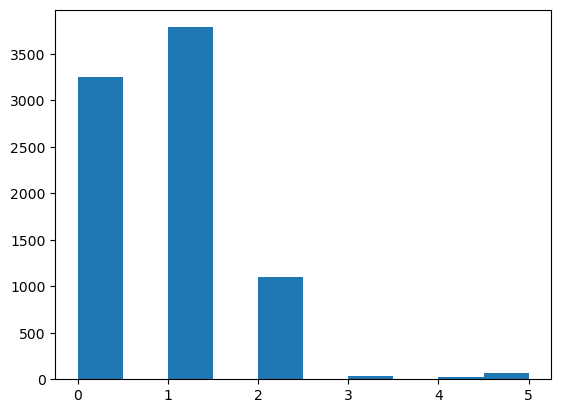

In [39]:
plt.hist(true_labels)

In [40]:
sum(p.numel() for p in model.parameters() if p.requires_grad) # number of trainable model parameters

11195270

In [41]:
# Generate the classification report
cr_df = pd.DataFrame(classification_report(true_labels, pred_labels, target_names=cor_labels, output_dict=True)).transpose()
print(cr_df)

              precision    recall  f1-score      support
0              0.877424  0.821538  0.848562  3250.000000
1              0.945411  0.933421  0.939378  3785.000000
2              0.635499  0.730419  0.679661  1098.000000
3              0.166667  0.558824  0.256757    34.000000
4              0.473684  0.692308  0.562500    26.000000
5              0.419355  0.412698  0.416000    63.000000
accuracy       0.856105  0.856105  0.856105     0.856105
macro avg      0.586340  0.691535  0.617143  8256.000000
weighted avg   0.868724  0.856105  0.861095  8256.000000


In [42]:
for c in cor_labels:
    print(test_df.loc[test_df['code'] == c].shape[0])

3250
3785
1098
34
26
63


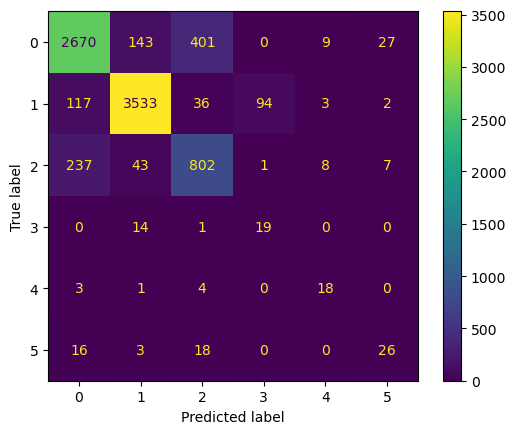

In [43]:
class_label_names = cor_labels # get these smartly somehow... categories got a bit mixed up
class_labels = class_codes_numbers
cm = confusion_matrix(true_labels, pred_labels, labels=cor_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cor_labels)
disp.plot()